In [29]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

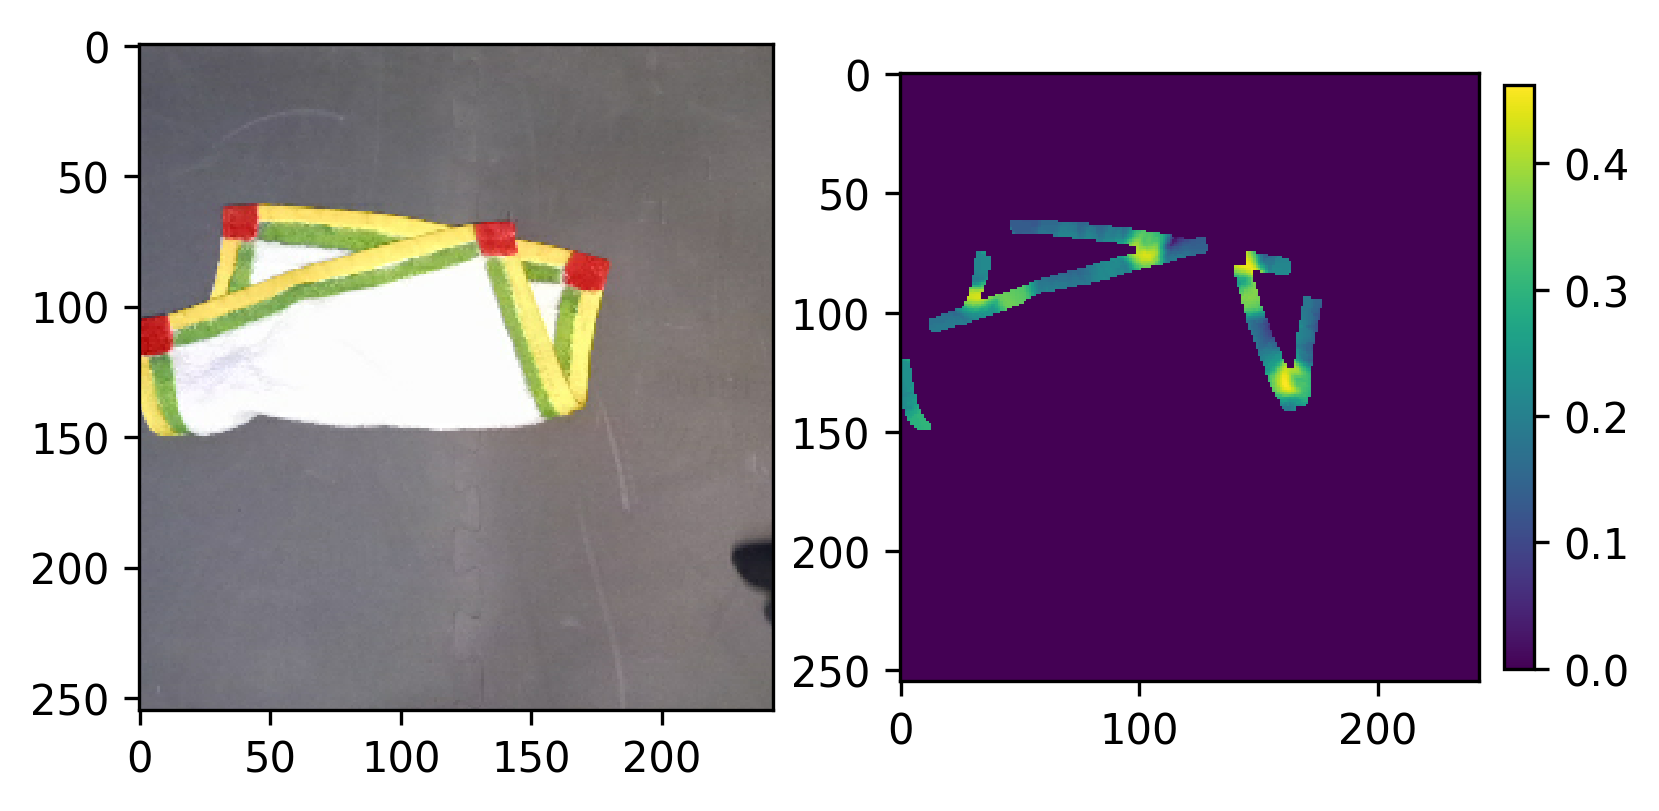

In [38]:
# Checking variance
path = "/home/jianingq/data_studio_painted_towel_r0.1"

var_map = np.load(os.path.join(path, 'camera_3', "490_variance.npy"))
var_map.shape

rgb = Image.open(os.path.join(path, 'camera_3', "rgb_490.png"))

# Visualize the var_map

plt.figure(dpi=300)
plt.subplot(121)
plt.imshow(rgb)
plt.subplot(122)
plt.imshow(var_map)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 1.100e+01, 1.200e+01, 1.400e+01, 8.000e+00,
        6.000e+00, 2.500e+01, 2.800e+01, 1.100e+01, 2.200e+01, 1.400e+01,
        2.100e+01, 4.300e+01, 2.100e+01, 3.500e+01, 4.400e+01, 4.500e+01,
        3.500e+01, 3.700e+01, 3.300e+01, 3.300e+01, 4.500e+01, 6.200e+01,
        5.700e+01, 9.100e+01, 9.100e+01, 9.400e+01, 8.200e+01, 1.010e+02,
        1.140e+02, 1.110e+02, 1.280e+02, 1.430e+02, 1.560e+02, 2.250e+02,
        2.770e+02, 4.720e+02, 1.322e+0

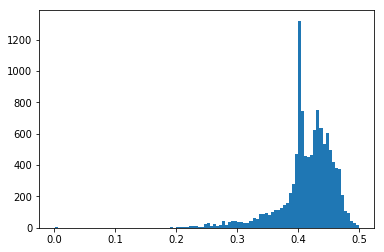

In [22]:
# plot histogram of max variances
maxvars = np.load(os.path.join(path, 'metadata', 'maxvars.npy'))
median = np.median(maxvars)
plt.hist(maxvars, bins=100)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


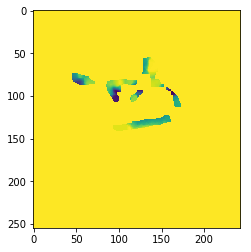

In [25]:
inverse_var = np.load(os.path.join(path, 'camera_3', '0_inverse_variance.npy'))
print(inverse_var)
plt.imshow(inverse_var)
plt.show()

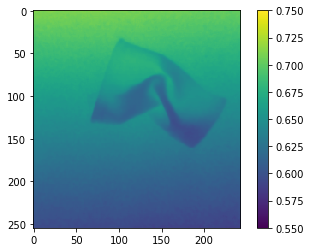

In [514]:
# Making a heightmap
path = "/home/jianingq/data_studio_painted_towel_r0.1/camera_3"

depth = np.load(os.path.join(path, "0_depth.npy"))

plt.imshow(depth, vmin=0.55, vmax=0.75)
plt.colorbar()
plt.show()

In [515]:
D = [0.6862431764602661, -2.8917713165283203, 0.0004992862232029438, -4.462565993890166e-05, 1.6113708019256592, 0.5638872385025024, -2.7169768810272217, 1.540696382522583]
D = np.array(D)
K = [611.1693115234375, 0.0, 638.8131713867188, 0.0, 611.1657104492188, 367.74871826171875, 0.0, 0.0, 1.0]
K = np.array(K).reshape((3, 3))

# Fill holes
zeros = np.where(depth == 0)
mask = np.zeros_like(depth, np.uint8)
mask[zeros] = 1
depth = cv2.inpaint(depth, mask, 3, cv2.INPAINT_NS)

fx = K[0, 0]
fy = K[1, 1]
cx = K[0, 2]
cy = K[1, 2]

# Get 3D point from 2D pixels
y_size, x_size = depth.shape[:2]
print(y_size, x_size)
xmap, ymap = np.meshgrid(np.arange(x_size), np.arange(y_size))
u = xmap.reshape(-1,1).astype(np.float32)
v = ymap.reshape(-1,1).astype(np.float32)
z = depth.reshape(-1,1).astype(np.float32)

# Undistort 3D points
col_start, row_start = [450, 180]
points = np.hstack([u + col_start, v + row_start])
depth_undistort = cv2.undistortPoints(np.expand_dims(points, axis=0), K, D, P=K)
depth_undistort = np.squeeze(depth_undistort)
u_undistort, v_undistort = zip(*depth_undistort)
u_undistort = np.array(u_undistort)
v_undistort = np.array(v_undistort)
x = (np.expand_dims(u_undistort, axis=1)-cx)*z/fx
y = (np.expand_dims(v_undistort, axis=1)-cy)*z/fy

# Make point cloud
cloud = np.concatenate((x, y, z), axis=1).astype(np.float64)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud)
# o3d.visualization.draw_geometries([pcd])

255 243


[[-4.10725682e-03  9.80725638e-01 -1.95346753e-01  6.67900000e-01]
 [ 9.99865921e-01  9.31027907e-04 -1.63484836e-02  3.02000000e-02]
 [-1.58515037e-02 -1.95387709e-01 -9.80597967e-01  6.40700000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
CAM2MID
 [[ 9.80725638e-01  9.31027907e-04 -1.95387709e-01 -7.18305481e-02]
 [-4.10725682e-03  9.99865921e-01 -1.58515037e-02 -6.43556688e-02]
 [ 1.95346753e-01  1.63484836e-02  9.80597967e-01  6.48999989e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
WORLD2MID
 [[-0.04621654  0.9773967  -0.2063001   0.47829973]
 [ 0.9773967   0.00159453 -0.21140756 -0.052291  ]
 [-0.2063001  -0.21140756 -0.955378    0.01800486]
 [ 0.          0.          0.          1.        ]]


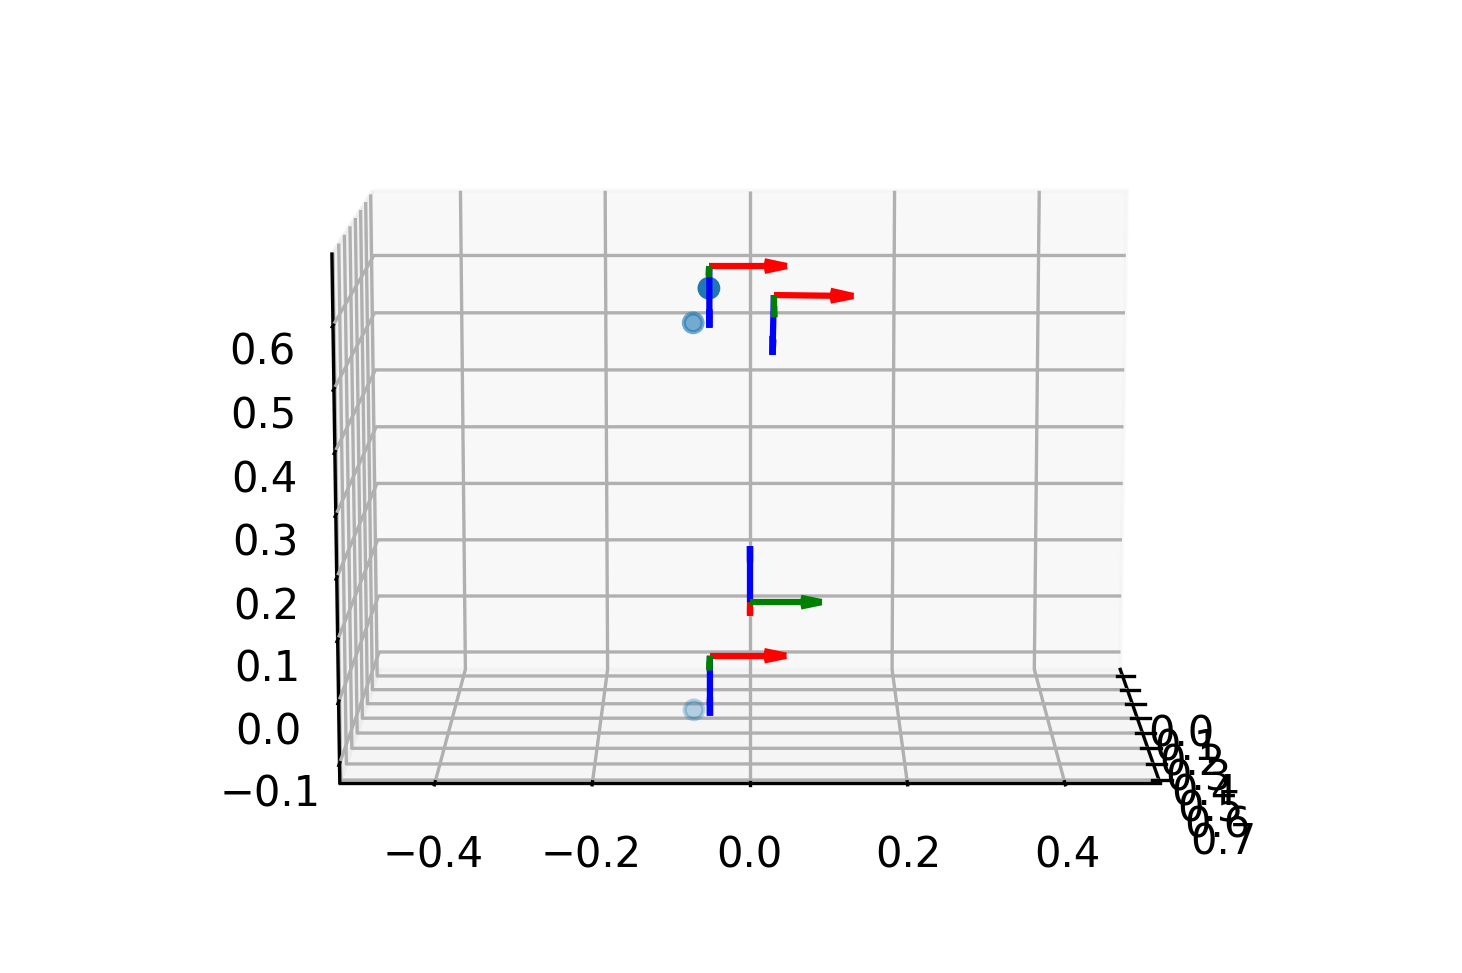

In [505]:
from pyquaternion import Quaternion as Quat
# Camera extrinsics
w2c_pose = [0.6679, 0.0302, 0.6407, 0.70277, 0.70456, -0.07513, -0.06369]
# w2c_pose = [0.0302, 0.6679, 0.6407, 0.70277, 0.70456, -0.07513, -0.06369]
qcam = Quat(x=w2c_pose[3], y=w2c_pose[4], z=w2c_pose[5], w=w2c_pose[6]).unit
T_world2cam = qcam.transformation_matrix
T_world2cam[0:3, 3] = w2c_pose[0:3]

unitv = np.array([0., 0., 1.]) # rotate world frame z axis
unitvx = np.array([1., 0., 0.])
unitvy = np.array([0., 1., 0.])
camv = qcam.rotate(unitv)
camvx = qcam.rotate(unitvx)
camvy = qcam.rotate(unitvy)
print(T_world2cam)

# Get middle point of depth and plot that
y = int(y_size / 2)
x = int(x_size / 2)
points = np.array([[x + col_start, y + row_start]], dtype=np.float32)
pt_undistorted = cv2.undistortPoints(np.expand_dims(points, axis=0), K, D, P=K)
pt_undistorted = np.squeeze(pt_undistorted, axis=0)
pz = depth[y][x]
px = (pt_undistorted[0, 0] - cx) / fx * pz
py = (pt_undistorted[0, 1] - cy) / fy * pz


qmid = Quat(x=1, y=1, z=0, w=0).unit
qdiff = qmid * qcam.inverse
# qdiff = qmid
T_cam2mid = qdiff.transformation_matrix
T_cam2mid[0:3, 3] = [px, py, pz]
T_world2mid = T_world2cam.dot(T_cam2mid)
from copy import deepcopy
midv = qmid.rotate(unitv)
midvx = qmid.rotate(unitvx)
midvy = qmid.rotate(unitvy)
# midv = qdiff.rotate(unitv)
# midvx = qdiff.rotate(unitvx)
# midvy = qdiff.rotate(unitvy)

# T_world2orth = deepcopy(T_world2mid)
# qorth = Quat(x=0, y=0, z=0, w=1).unit
# qdiff = qorth * qcam.inverse
# qdiff = qorth
# T_mid2orth = qdiff.transformation_matrix
# T_mid2orth[2, 3] -= T_world2cam[2, 3]
# print(T_mid2orth)
# T_world2orth = T_world2mid.dot(T_mid2orth)
T_world2orth = deepcopy(T_world2mid)
T_world2orth[2, 3] += T_world2cam[2, 3]

orthv = qmid.rotate(unitv)
orthvx = qmid.rotate(unitvx)
orthvy = qmid.rotate(unitvy)

print("CAM2MID\n", T_cam2mid)
print("WORLD2MID\n", T_world2mid)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(dpi=300)
ax = fig.gca(projection='3d')

x = [0.0, T_world2cam[0, 3], T_world2mid[0, 3], T_world2orth[0, 3]]
y = [0.0, T_world2cam[1, 3], T_world2mid[1, 3], T_world2orth[1, 3]]
z = [0.0, T_world2cam[2, 3], T_world2mid[2, 3], T_world2orth[2, 3]]
u = [0.0, camv[0], midv[0], orthv[0]]
v = [0.0, camv[1], midv[1], orthv[1]]
w = [1.0, camv[2], midv[2], orthv[2]]
ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, color='blue')
u = [1.0, camvx[0], midvx[0], orthvx[0]]
v = [0.0, camvx[1], midvx[1], orthvx[1]]
w = [0.0, camvx[2], midvx[2], orthvx[2]]
ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, color='red')
u = [0.0, camvy[0], midvy[0], orthvy[0]]
v = [1.0, camvy[1], midvy[1], orthvy[1]]
w = [0.0, camvy[2], midvy[2], orthvy[2]]
ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, color='green')

ptz = np.array([0, 0, 0.1, 1])
pty = np.array([0, 0.1, 0, 1])
ptm_z = T_world2mid.dot(ptz)
pt_z = T_world2orth.dot(ptz)
pt_y = T_world2orth.dot(pty)

ax.scatter([pt_z[0], ptm_z[0], pt_y[0]], [pt_z[1], ptm_z[1], pt_y[1]], [pt_z[2], ptm_z[2], pt_y[2]])

ax.view_init(elev=10., azim=-0)
ax.set_ylim3d((-0.5, 0.5))
plt.show()

[[ 9.80725638e-01  9.31027907e-04 -1.95387709e-01 -8.19866066e-02]
 [-4.10725682e-03  9.99865921e-01 -1.58515037e-02 -1.89540574e-01]
 [ 1.95346753e-01  1.63484836e-02  9.80597967e-01 -2.79269129e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.08198661 -0.18954057 -0.27926913]


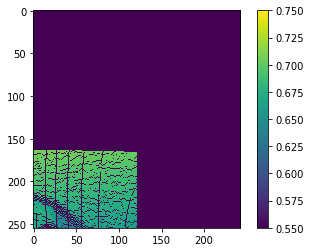

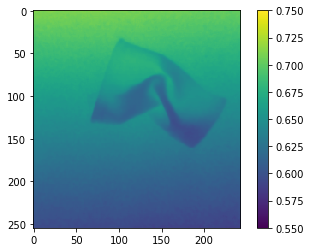

In [511]:
# Reproject points
# qorth = Quat(x=0, y=0, z=0, w=1)
# T_mid2orth = qorth.transformation_matrix
# T_mid2orth[0:3, 3] = [0, 0, pz]
# T_mid2orth[0:3, 3] = [0, 0, 0.2]

# T_cam2world1 = deepcopy(T_world2cam)
# T_cam2world1[0:3, 3] *= -1
# T_cam2world1[0:3, 0:3] = np.linalg.inv(deepcopy(T_cam2world1[0:3, 0:3]))
# T_cam2orth = T_cam2world1.dot(T_world2orth)

T_cam2world = np.linalg.inv(deepcopy(T_world2cam))
T_cam2orth = T_cam2world.dot(T_world2orth)
T_cam2orth[2, 3] -= 0.3


# print(T_cam2world)

# print(T_cam2world == T_cam2world1)
# print(T_cam2world)
# T_cam2orth[2, 3] += 0.5
# T_cam2orth = T_cam2mid.dot(T_mid2orth)
# T_cam2orth = T_mid2orth
# T_cam2orth = T_cam2mid
print(T_cam2orth)

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# x = [0.0, T_cam2orth[0, 3]]
orthvx = qdiff.rotate(unitvx)
# y = [0.0, T_cam2orth[1, 3]]
# z = [0.0, T_cam2orth[2, 3]]
# u = [0.0, 0.0]
# v = [0.0, 0.0]
# w = [1.0, 1.0]
# ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)
# ax.set_ylim3d((-0.25, 0.25))
# ax.set_zlim3d(-0.1, 0.1)
# plt.show()

# tvec = -T_cam2orth[0:3, 3]
tvec = (0.0, 0.2, 0.0) # similar x, negative y, similar z 
print(T_cam2orth[0:3, 3])
rvec = (0, 0, 0)
rvec, _ = cv2.Rodrigues(T_cam2orth[0:3, 0:3])
# print(rvec)
points = np.array(pcd.points).astype(np.float64)
depth_img = np.zeros(depth.shape)
if len(points) != 0:
    imagePoints, _ = cv2.projectPoints(points, rvec, tvec, K, D)
    imagePoints = imagePoints[:, 0, :]
    imagePoints = np.append(imagePoints, np.zeros((imagePoints.shape[0], 1)), axis=1)
    depths = points[:,2]
    for i in range(imagePoints.shape[0]):
        d = depths[i]
        py = int(np.rint(imagePoints[i, 1])) - row_start
        px = int(np.rint(imagePoints[i, 0])) - col_start
        if py < depth.shape[0] and px < depth.shape[1] and py >= 0 and px >= 0:
            depth_img[py, px] = d

plt.imshow(depth_img, vmin=0.55, vmax=0.75)
plt.colorbar()
plt.show()
plt.imshow(depth, vmin=0.55, vmax=0.75)
plt.colorbar()
plt.show()